# Preprocessing

In [34]:
import pandas as pd
import json

# Load the dataset JSON file
json_file_path = 'video_paths_2.json'  # Update this with the actual path to your JSON file
with open(json_file_path, 'r') as file:
    json_data = json.load(file)

# Load the fine action mapping JSON file
action_list_path = '/home/jupyter/acv/nsva_data/NSVA/SportsFormer/data/action_list_Event.json'
with open(action_list_path, 'r') as file:
    action_list = json.load(file)

# Load the coarse action mapping JSON file
coarse_action_list_path = '/home/jupyter/acv/nsva_data/NSVA/SportsFormer/data/action_list_Coarse.json'
with open(coarse_action_list_path, 'r') as file:
    coarse_action_list = json.load(file)

# Prepare a list to hold the data, each video's labels grouped together
data_entries = []
for split, videos in json_data.items():
    for video_path, class_labels in videos.items():
        data_entries.append({
            'split': split,
            'file_path': video_path,
            'class_labels': class_labels
        })

# Create a DataFrame
df = pd.DataFrame(data_entries)

# Function to map class_labels to fine actions and then to coarse actions
def map_to_fine_and_coarse_actions(class_labels):
    fine_actions = [action_list[int(label.split('action')[-1])] for label in class_labels if label.startswith('action')]
    coarse_actions = [coarse_action_list[action] for action in fine_actions if action in coarse_action_list]
    return coarse_actions

# Apply the mapping function to create new columns for fine and coarse actions
df['fine_actions'] = df['class_labels'].apply(lambda labels: [action_list[int(label.split('action')[-1])] for label in labels if label.startswith('action')])
df['coarse_actions'] = df['fine_actions'].apply(lambda actions: [coarse_action_list[action] for action in actions if action in coarse_action_list])

# Display the first few rows of the DataFrame and the number of unique coarse actions
print(df.head(20))

# Calculate and print the number of unique coarse actions
unique_coarse_actions = set()
for actions in df['coarse_actions']:
    unique_coarse_actions.update(actions)
num_coarse_classes = len(unique_coarse_actions)
print(f'Total number of unique coarse actions: {num_coarse_classes}')
# print(action_occurrences.to_dict())

print(unique_coarse_actions)

    split                              file_path            class_labels  \
0   train  ./pbp_videos/train/0021800013-109.mp4              [action53]   
1   train   ./pbp_videos/train/0021800013-11.mp4              [action44]   
2   train  ./pbp_videos/train/0021800013-110.mp4  [action109, action135]   
3   train  ./pbp_videos/train/0021800013-112.mp4  [action105, action135]   
4   train  ./pbp_videos/train/0021800013-114.mp4  [action109, action135]   
5   train  ./pbp_videos/train/0021800013-116.mp4              [action63]   
6   train  ./pbp_videos/train/0021800013-118.mp4    [action53, action18]   
7   train  ./pbp_videos/train/0021800013-127.mp4  [action111, action135]   
8   train  ./pbp_videos/train/0021800013-129.mp4  [action109, action135]   
9   train   ./pbp_videos/train/0021800013-13.mp4    [action46, action18]   
10  train  ./pbp_videos/train/0021800013-131.mp4              [action63]   
11  train  ./pbp_videos/train/0021800013-133.mp4              [action50]   
12  train  .

In [22]:
def dataframe_to_json_structure(df):
    json_structure = {}
    for split in df['split'].unique():
        split_df = df[df['split'] == split]
        file_structure = split_df.set_index('file_path')['coarse_actions'].to_dict()
        json_structure[split] = file_structure
    return json_structure

json_output = dataframe_to_json_structure(df)



In [1]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.transforms import Compose, Normalize, Resize, ToTensor



In [2]:
import json
import cv2
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from PIL import Image

# Tested working data set and video process

In [38]:
import torch
import json
import cv2
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


def visualize_attention(frame_tensor, attention_map):
    # Convert the frame tensor from PyTorch to NumPy and adjust for image display
    frame = frame_tensor.cpu().numpy().transpose(1, 2, 0)  # Change from CxHxW to HxWxC
    frame = (frame * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # Inverse normalize
    frame = np.clip(frame, 0, 1)  # Clip to valid [0,1] range for image data

    # Process the attention map
    attention = attention_map.cpu().numpy().squeeze(0)  # Squeeze out the channel dimension if it's 1xHxW

    # Create a figure with subplots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(frame)
    plt.title("Original Frame")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(frame)
    plt.imshow(attention, alpha=0.4, cmap='rainbow')  # Overlay the attention map with transparency
    plt.title("Frame with Attention Overlay")
    plt.axis('off')

    plt.show()

def load_custom_model(model_path, num_classes):
    # Create an instance of the model architecture with no pre-trained weights
    model = fasterrcnn_resnet50_fpn(pretrained=False)

    # Replace the classifier and box predictor head with a new one that matches the number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Load the state dictionary from the file
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))

    # Remove 'model.' prefix from the state dictionary keys if present
    new_state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}

    # Load the modified state dictionary into the model
    model.load_state_dict(new_state_dict)

    return model

custom_model_path = 'normalized_comprehensive_basketball_detector.pth'  
ball_detector = load_custom_model(custom_model_path, num_classes=4)
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")




frame_transforms = Compose([
    Resize(720),  # Resize smaller edge to 256 pixels
    ToTensor(),  # Convert the image to a PyTorch tensor
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet's mean and std
])
class VideoCaptionDataset(torch.utils.data.Dataset):
    def __init__(self, json_file, dataset_type='train', transform=None, total_samples=5):
        with open(json_file, 'r') as f:
            self.video_data = json.load(f)[dataset_type]
        self.transform = transform
        self.total_samples = total_samples
        # print(f"Loaded {len(self.video_data)} videos for {dataset_type}.")

    def __len__(self):
        return len(self.video_data)

    def __getitem__(self, idx):
        video_path, captions = list(self.video_data.items())[idx]
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_interval = max(1, total_frames // self.total_samples)

        # print(f"Loading video from path: {video_path}")
        frames = []
        frame_id = 0
        sample_count = 0
        while True:
            ret, frame = cap.read()
            if not ret or sample_count >= self.total_samples:
                break
            if frame_id % frame_interval == 0:
                frame_data = self.process_frame(frame)
                frames.append(frame_data)
                sample_count += 1

            frame_id += 1

        
        cap.release()
        # del ball_detector
        # Clear CUDA cache to free unused memory from GPU
        torch.cuda.empty_cache()
        
        frames_tensor = torch.stack([f['frame'] for f in frames]) if frames else torch.tensor([], dtype=torch.float32)
        attention_maps = torch.stack([f['attention_map'] for f in frames]) if frames else torch.tensor([], dtype=torch.float32)

        video_data = {
            'frames': frames_tensor,
            'frame_details': frames,  # Each frame's data including detections and attention maps
            'attention_maps': attention_maps,  # Stacked attention maps for each frame
            'captions': captions
        }
        return video_data


    def process_frame(self, frame):
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(rgb_frame)
        frame_tensor = self.transform(frame_pil) if self.transform else frame_pil
        ball_detector.eval()
        frame_tensor = frame_tensor.to(device)
        ball_detector.to(device)
        with torch.no_grad():
            basketball_det_out = ball_detector([frame_tensor])[0]
        # ball_detector.to('cpu')
        detections = self.process_detections(basketball_det_out, 0.4)

        attention_map = self.generate_attention_maps(detections, frame_tensor)

        return {
            'frame': frame_tensor,
            'detections': detections,
            'attention_map': attention_map
        }


    def generate_attention_maps(self, detections, frame_tensor):
        _, height, width = frame_tensor.shape  # Assuming frame_tensor is CxHxW

        # Initialize the attention map tensor to zeros
        attention_map = torch.zeros((1, height, width), dtype=torch.float32, device=device)#change 1 to 3 when actually in use not visualizing

        for box, label in zip(detections['boxes'], detections['labels']):
            # Define weights based on class labels
            if label == 2:  # Assuming label 2 is the 'ball'
                weight = 2.0  # Highest weight for balls
            elif label == 3:  # Assuming label 3 is the 'rim'
                weight = 1.5  # Middle weight for rims
            else:
                weight = 0.5  # Lower weight for players and others

            x1, y1, x2, y2 = map(int, [box[0], box[1], box[2], box[3]])
            x1, x2 = max(0, x1), min(width, x2)
            y1, y2 = max(0, y1), min(height, y2)

            if (x2 > x1) and (y2 > y1):
                attention_map[0, y1:y2, x1:x2] = weight

        # Normalize the attention map to range between 0 and 1
        max_val = torch.max(attention_map)
        if max_val > 0:
            attention_map /= max_val
            
        visualize_attention(frame_tensor, attention_map)


        return attention_map


    def process_detections(self, detection_output, threshold=.6):
        scores = detection_output['scores']
        high_confidence_indices = scores > threshold
        processed_output = {k: v[high_confidence_indices].cpu() for k, v in detection_output.items()}
        return processed_output

    def process_segmentations(self, segmentation_output):
        thresholded_output = segmentation_output > 0.8
        return thresholded_output.squeeze(1).cpu().byte()


In [39]:
import numpy as np
import cv2
from torchvision.transforms import ToPILImage
from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm  


BASKETBALL_LABEL_MAP = [
    "empty", "ball", "player", "rim"  # Assuming 'empty' is the background class
]

BASKETBALL_COLOR_MAP = {
    "player": (255,250,205),   # Red
    "rim": (0, 255, 0),      # Green
    "ball": (0, 255, 0)      # Blue
}


def draw_boxes(image, boxes, labels, colors):
    for box, label, color in zip(boxes, labels, colors):
        top_left = (int(box[0]), int(box[1]))
        bottom_right = (int(box[2]), int(box[3]))
        image = cv2.rectangle(image, top_left, bottom_right, color, 2)
        image = cv2.putText(image, label, (top_left[0], top_left[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return image

def denormalize(tensor, mean, std):
    """
    Denormalizes a given tensor using the specified mean and standard deviation.
    This operation reverses the normalization applied during preprocessing.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Scale by standard deviation and add mean
    return tensor

def process_video(dataset, video_index, output= 'hi_res_30_fps.mp4', segment=False, detect=True, display = False, save=True):
    """
    Processes a single video from the dataset, drawing bounding boxes and segmentation masks.
    """
    print("start")
    video_data = dataset[video_index]
    print("getting frames")
    frame_details = video_data['frame_details']
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    if save:
        video_writer = cv2.VideoWriter(output, fourcc, 60, (1280, 720))##MUST MATCH TRANSFORM, Number inversed
        
    # Denormalization parameters
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    convert_to_pil = ToPILImage()
    
    print("converting")
    convert_to_pil = ToPILImage()

    # Iterate over frames with a progress bar
    for i in tqdm(range(len(frame_details)), desc="Processing Frames"):
        frame_data = frame_details[i]
        frame_tensor = frame_data['frame']
        # Denormalize the frame tensor tp visualize
        denormalized_frame = denormalize(frame_tensor.clone(), mean, std)

        # Convert to PIL and then to numpy array for OpenCV operations
        frame_pil = convert_to_pil(denormalized_frame)

        frame_np = np.array(frame_pil)  # Convert to numpy array for CV2 processing

        # Apply segmentation masks
        if segment:
            segmentation_masks = frame_data['segmentations']
            overlay = np.zeros_like(frame_np, dtype=np.uint8)
            for mask in segmentation_masks:
                mask_np = mask.numpy()
                # Overlay the mask on the frame
                for channel in range(min(mask_np.shape[0], frame_np.shape[2])):
                    overlay[:, :, channel] = mask_np[channel] * 255
                cv2.addWeighted(overlay, 0.5, frame_np, 1, 0, frame_np)

        # Draw basketball detection boxes
        if detect:
            detections = frame_data['detections']
            if detections['boxes'].nelement() > 0:
                basketball_boxes = detections['boxes'].numpy()
                basketball_labels = [BASKETBALL_LABEL_MAP[l] for l in detections['labels'].numpy()]
                box_colors = [BASKETBALL_COLOR_MAP[label] for label in basketball_labels]
                frame_np = draw_boxes(frame_np, basketball_boxes, basketball_labels, box_colors)

        # Display and save frames
        if display:
            plt.figure(figsize=(12, 8))
            plt.imshow(frame_np)
            plt.axis('off')
            plt.show()
        if save:
            video_writer.write(cv2.cvtColor(frame_np, cv2.COLOR_RGB2BGR))

    if save:
        video_writer.release()
    print("Video processing complete.")


start


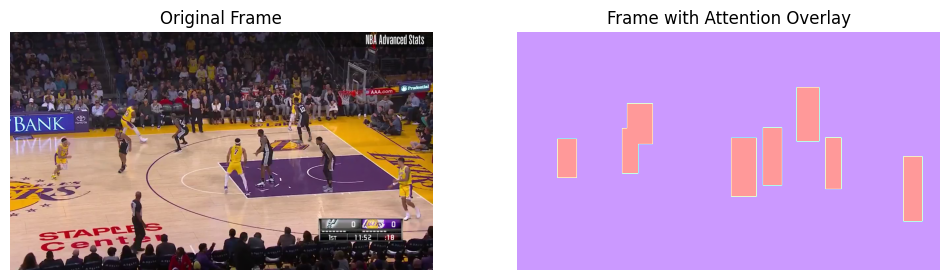

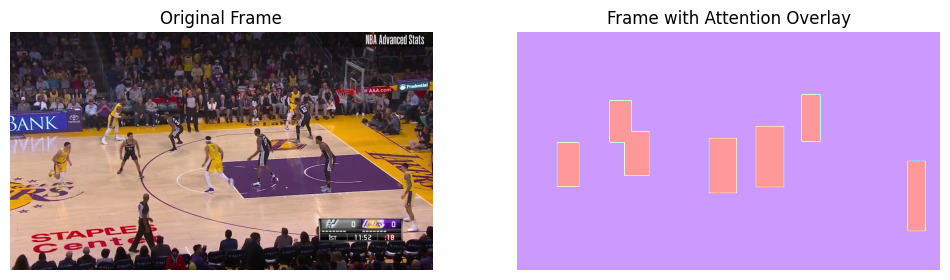

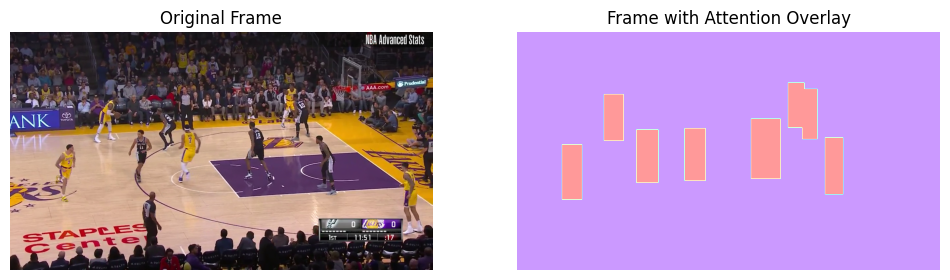

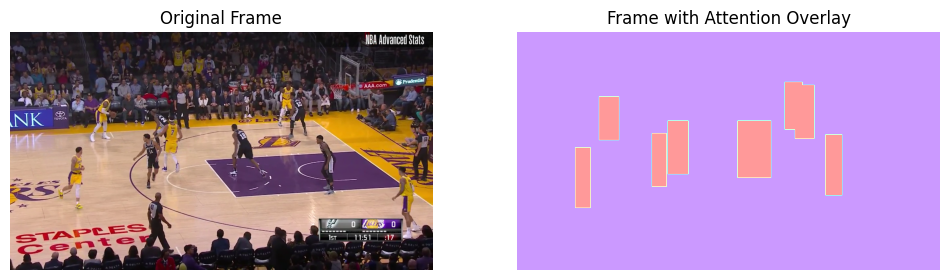

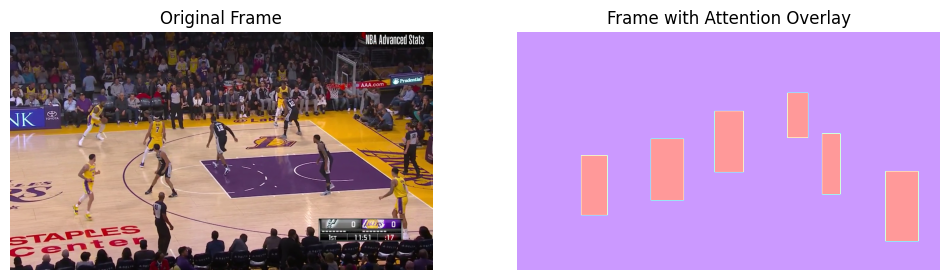

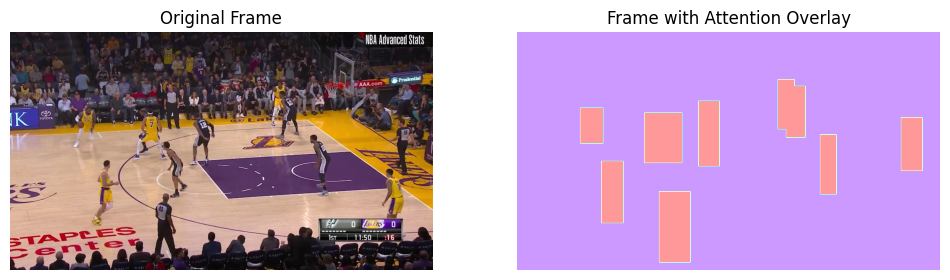

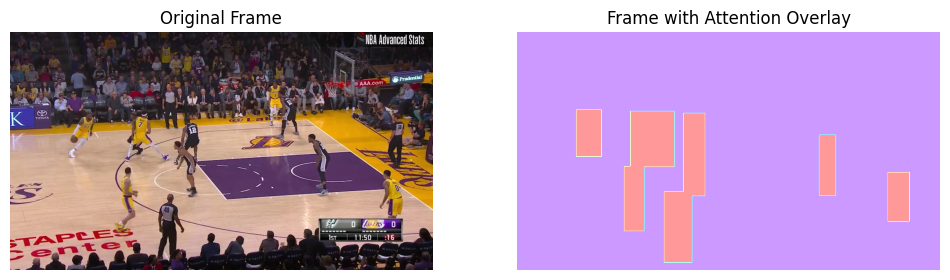

In [ ]:
def test_video_processing():
    dataset = VideoCaptionDataset(json_file="coarse_actions_paths.json", dataset_type='train', transform=frame_transforms, total_samples = 30)
    process_video(dataset, 945, display=True, save=False)
    print("video done")

test_video_processing()

In [49]:

def test_video_loading():
    # Use a sample video and check the frame loading logic
    dataset = VideoCaptionDataset(json_file="coarse_actions_paths.json", dataset_type='train', transform=frame_transforms)
    video_data = dataset.__getitem__(3)  # Load the fourth item (index starts from 0)
    
    # Extract frame details
    frame_details = video_data['frame_details']

    print(f"Number of frames: {len(frame_details)}")  # Number of detailed frame entries
    print(f"Captions: {video_data['captions']}")  # Captions associated with the video
    # print(f"Frames: {video_data['frames']}") 
    # Now loop through each frame detail and print detections and segmentations
    for i, frame in enumerate(frame_details):
        print(f"Frame {i + 1} detections: {frame['detections']}")
        print(f"Frame {i + 1} attention map: {frame['attention_map']}")        
        #print(f"Frame {i + 1} segmentations: {frame['segmentations']}")

# Run the test
test_video_loading()


Loaded 24138 videos for train.
Loading video from path: ./pbp_videos/train/0021800013-112.mp4
Number of frames: 5
Captions: ['Shot', 'Rebound']
Frame 1 detections: {'boxes': tensor([[100.8737, 102.0793, 109.5768, 112.0013],
        [ 65.4931,  75.9020, 100.3236, 143.3089],
        [ 87.9165,  38.4126, 126.0437, 103.8151],
        [292.1655,  37.0330, 332.1680, 112.5845],
        [276.9761,  79.4243, 327.3714, 176.4075]]), 'labels': tensor([1, 2, 2, 2, 2]), 'scores': tensor([0.9977, 0.9950, 0.9941, 0.8273, 0.7518])}
Frame 1 attention map: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
Frame 2 detections: {'boxes': tensor([[110.5831,  63.7614, 148.4384, 121.1042],
        [317.5146,  10.0671, 334.8464,  61.2217],
        [ 56.8543,  75.2165,  94.1028, 131.8825

# Multimodal model

append video details on to frames tensor and train r2d+1, like in concatonation model of hw. or use transformer. APPEND the frame details of each frame to its respective frame

In [62]:
!pip install pytorch-lightning

In [64]:
!pip install torchmetrics

Runs into multiprocessing issues when run from notebook. Run from .py files instead

In [3]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataloader import default_collate
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import F1Score, Accuracy
from torchmetrics import Accuracy, Precision, Recall
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision.models.video import r2plus1d_18,R2Plus1D_18_Weights 
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torch
from torchmetrics import Accuracy, Precision, Recall
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import MultilabelAccuracy
from torchmetrics.classification import MultilabelPrecision
from torchmetrics.classification import MultilabelRecall
import torch.multiprocessing as mp
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import Subset
import random
from torch.utils.data import DataLoader
import gc
from dataset import VideoCaptionDataset
from custom_collate_fn import custom_collate_fn

mp.set_start_method('spawn', force=True)
torch.cuda.empty_cache()  # Clear unused memory

caption_mapping = {
    'Shot': 0,
    'Rebound': 1,
    'Turnover': 2,
    'Foul': 3,
    'Free_Throw': 4,
    'Jump_Ball': 5,
    'Violation': 6,
    'Timeout-Regular': 7,
    'period-start': 8,
    'period-end': 9,
    'Ejection-Other': 10
}
num_labels = len(caption_mapping)  # Should be 11 in this case


class VideoClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.save_hyperparameters()
        self.model = r2plus1d_18(weights=R2Plus1D_18_Weights.KINETICS400_V1) # Load a pretrained R(2+1)D model
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)
        # Metrics
        self.train_accuracy = MultilabelAccuracy(num_labels=num_labels, average='macro')
        self.val_accuracy = MultilabelAccuracy(num_labels=num_labels, average='macro')
        self.precision = MultilabelPrecision(num_labels=num_labels, average='macro')
        self.recall = MultilabelRecall(num_labels=num_labels, average='macro')
        self.f1_score = F1Score(task="multilabel",num_labels=num_labels, average='macro')
        #loss
        self.loss_function = torch.nn.BCEWithLogitsLoss()
        
    def report_memory(self):
        allocated = torch.cuda.memory_allocated() / 1e9
        cached = torch.cuda.memory_reserved() / 1e9
        print(f"Allocated: {allocated:.2f} GB")
        print(f"Cached: {cached:.2f} GB")

    def forward(self, x):
        return torch.sigmoid(self.model(x))  # Use sigmoid for multi-label classification
    

    def training_step(self, batch, batch_idx):
        
        if batch_idx % 50 == 0:
            self.report_memory()
        
        frames, attention_maps, labels = batch['frames'], batch['attention_maps'], batch['captions']
        # frames = frames * attention_maps.unsqueeze(2)  # Broadcasting the attention map across the channel dimension
        frames = frames.permute(0, 2, 1, 3, 4)  # New shape: [batch_size, 3, num_frames, height, width
        attention_maps = attention_maps.permute(0, 2, 1, 3, 4)
        
        frames *= attention_maps  # Element-wise multiplication
        outputs = self(frames)
        
        #loss
        loss = self.loss_function(outputs, labels)
        if torch.isnan(loss).any() or torch.isinf(loss).any():
            raise ValueError("Loss contains NaN or infinite values")
            
        #log loss and accuracy
        # self.train_accuracy(outputs, labels)
        self.log('train_loss', loss,  on_step=True, on_epoch=True, logger=True, prog_bar=True)
        # self.log('train_acc', self.train_accuracy.compute(), on_step=False, on_epoch=True, logger=True, prog_bar=True)
                
        if batch_idx % 50 == 0:
            self.report_memory()
            gc.collect()
            torch.cuda.empty_cache()
            self.report_memory()
        
        # return loss

    def validation_step(self, batch, batch_idx):
        frames, attention_maps, labels = batch['frames'], batch['attention_maps'], batch['captions']
        frames = frames.permute(0, 2, 1, 3, 4)  # New shape: [batch_size, 3, num_frames, height, width
        attention_maps = attention_maps.permute(0, 2, 1, 3, 4)
        
        frames *= attention_maps  # Element-wise multiplication
        outputs = self(frames)
        
        #loss
        loss = self.loss_function(outputs, labels)
        
        self.log('val_loss', loss, prog_bar=True)
        # self.val_accuracy(outputs, labels)
        # self.log('val_acc', self.val_accuracy.compute(), on_step=False, on_epoch=True, logger=True, prog_bar=True)
        # self.log('val_precision', self.precision(outputs, labels), on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log('val_recall',  self.recall(outputs, labels), on_step=False, on_epoch=True, logger=True, prog_bar=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        pl.Trainer(gradient_clip_val=1.0)  # Adjust value as needed
        return optimizer

frame_transforms = Compose([Resize(224),  # Resize smaller edge to 256 pixels
                            ToTensor(),  # Convert the image to a PyTorch tensor
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet's mean and std
                           ])
# Your code for defining dataset
dataset = VideoCaptionDataset(json_file='coarse_actions_paths.json', dataset_type='train', total_samples=16, transform=frame_transforms)
val_dataset = VideoCaptionDataset(json_file='coarse_actions_paths.json', dataset_type='val', total_samples=16, transform=frame_transforms)


batch_size = 1
num_workers = 0 # number of cpu cores




video_classifier = VideoClassifier(num_classes=11)
import json
from collections import Counter
from tqdm import tqdm
def get_class_distribution_from_json(json_file, dataset_type='train'):
    """Calculate the distribution of classes directly from a JSON file."""
    # Load the JSON data
    with open(json_file, 'r') as file:
        data = json.load(file)[dataset_type]

    class_counts = Counter()
    
    # Iterate over each video and its corresponding actions
    for video_path, actions in tqdm(data.items(), desc=f'Processing {dataset_type} data'):
        # Update the count for each action in the list
        class_counts.update(actions)

    return class_counts

import numpy as np
from torch.utils.data import DataLoader, Subset

import json

def get_video_data(json_file_path):
    """Load video data from a JSON file."""
    with open(json_file_path, 'r') as file:
        return json.load(file)
    
json_file_path = 'coarse_actions_paths.json'
video_data = get_video_data(json_file_path)


def stratify_data(class_distribution, dataset, num_samples):
    """ Create stratified sample indices for the dataset. """
    indices_per_class = {action: set() for action in class_distribution}
    for idx, (video_path, actions) in enumerate(dataset.items()):
        for action in actions:
            indices_per_class[action].add(idx)

    # Compute the number of samples we need from each class
    num_samples_per_class = {action: int(np.round(num_samples * (count / sum(class_distribution.values()))))
                             for action, count in class_distribution.items()}

    selected_indices = set()
    for action, indices in indices_per_class.items():
        if indices:
            selected_indices.update(np.random.choice(list(indices), min(len(indices), num_samples_per_class[action]), replace=False))

    return list(selected_indices)

# Assume `video_data` is your loaded JSON structure with paths and actions
train_class_distribution = get_class_distribution_from_json(json_file_path, 'train')
val_class_distribution = get_class_distribution_from_json(json_file_path, 'val')

# Now, you can use the stratify_data function to get stratified indices for both train and val sets.
train_indices = stratify_data(train_class_distribution, video_data['train'], 5)
val_indices = stratify_data(val_class_distribution, video_data['val'], 1)

# # Assuming you have a custom dataset class VideoCaptionDataset that uses these indices
train_subset = Subset(dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

# Create the DataLoaders with the stratified subsets
train_loader_50 = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn,num_workers=num_workers)
val_loader_50 = DataLoader(val_subset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn, num_workers=num_workers)



# Logger
logger = TensorBoardLogger("tb_logs", name="video_classifier")

# Checkpoint
checkpoint_callback = ModelCheckpoint(
    # monitor='val_loss', 
                                      dirpath='tb_logs_new', 
                                      # filename='video_classifier-{epoch:02d}-{val_loss:.2f}', 
                                      filename='ur_mom', 
                                      every_n_epochs=1,        # Save a checkpoint after every epoch
                                      verbose=True             # Print out messages when saving checkpoints
)

# Trainer
trainer = pl.Trainer(max_epochs=2, 
                     callbacks=[checkpoint_callback],
                     # precision=16,
                     logger=logger)




Processing train data: 100%|██████████| 24138/24138 [00:00<00:00, 1053266.79it/s]

Processing val data: 100%|██████████| 3929/3929 [00:00<00:00, 1039252.09it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
trainer.fit(video_classifier, train_loader_50, val_loader_50)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type                | Params
-------------------------------------------------------
0 | model          | VideoResNet         | 31.3 M
1 | train_accuracy | MultilabelAccuracy  | 0     
2 | val_accuracy   | MultilabelAccuracy  | 0     
3 | precision      | MultilabelPrecision | 0     
4 | recall         | MultilabelRecall    | 0     
5 | f1_score       | MultilabelF1Score   | 0     
6 | loss_function  | BCEWithLogitsLoss   | 0     
-------------------------------------------------------
31.3 M    Trainable params
0         Non-trainable params
31.3 M    Total params
125.223   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Allocated: 0.30 GB
Cached: 0.38 GB
Allocated: 3.87 GB
Cached: 3.93 GB
Allocated: 3.87 GB
Cached: 3.90 GB


Validation: |          | 0/? [00:00<?, ?it/s]

Allocated: 0.30 GB
Cached: 0.38 GB
Allocated: 3.87 GB
Cached: 3.93 GB
Allocated: 3.87 GB
Cached: 3.90 GB


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [11]:
!pip install tensorboard

In [24]:
%reload_ext tensorboard
%tensorboard --logdir=/home/jupyter/acv/logs_PLATINUM

Create a paths json using the course actions. Significantly less classes